In [55]:
# Seed and Versions
import sys
import platform
from importlib.metadata import version
from pathlib import Path

# Ensure project root is on sys.path (handles running from repo root or notebooks/)
def _add_project_root_to_sys_path() -> None:
    candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for base in candidates:
        if (base / "pyproject.toml").exists() or (base / "src").exists():
            if str(base) not in sys.path:
                sys.path.insert(0, str(base))
            return

_add_project_root_to_sys_path()

from src.utils import set_seed

set_seed(42)
print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "pandas": version("pandas"),
})


{'python': '3.11.3', 'platform': 'macOS-15.6-arm64-arm-64bit', 'pandas': '2.2.2'}


# 04 - Report Figures

Generate figures for the executive summary.


## Overview

- Load `data/processed/merged.csv`
- Create: (1) boxplot returns by sector, (2) returns vs sentiment bins, (3) PCA scatter
- Save figures to `reports/figures/` with `src.plot.savefig` (dpi=150)


## Imports and Data Load


In [56]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from src.utils import read_csv_safe, validate_columns
from src.plot import savefig

# Resolve project root so paths are correct when running from notebooks/
def _resolve_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for base in candidates:
        if (base / "pyproject.toml").exists() and (base / "data").exists():
            return base
    return Path.cwd()

PROJECT_ROOT = _resolve_root()
MERGED_PATH = PROJECT_ROOT / "data/processed/merged.csv"

df = read_csv_safe(MERGED_PATH, parse_dates=["date"]) if MERGED_PATH.exists() else pd.DataFrame()
if not df.empty:
    validate_columns(df, [
        "date","ticker","sector","close","volume","volatility","return","sentiment_score","n_headlines"
    ])

# Prepare sentiment bins for figure 2
if not df.empty and "sentiment_score" in df.columns:
    def _bin(x: float) -> str:
        if x <= -0.2:
            return "neg"
        if x >= 0.2:
            return "pos"
        return "neu"
    df["sentiment_bin"] = df["sentiment_score"].apply(_bin)


## Figure 1: Boxplot of Returns by Sector


In [57]:
print("Saved:", (PROJECT_ROOT / "reports/figures/figure_returns_by_sector.png").as_posix())


Saved: /Users/christopherdefazio/Code/mixed-methods-market-analysis/reports/figures/figure_returns_by_sector.png


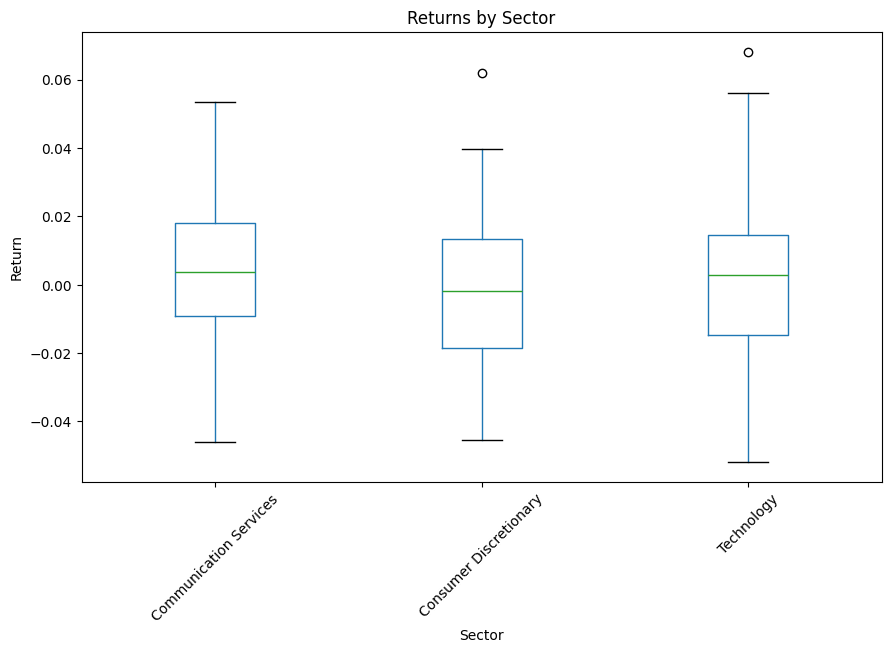

In [58]:
# Generate and save figure 1
if not df.empty:
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    df.boxplot(column="return", by="sector", ax=ax1, grid=False, rot=45)
    ax1.set_title("Returns by Sector")
    ax1.set_xlabel("Sector")
    ax1.set_ylabel("Return")
    plt.suptitle("")
    savefig(PROJECT_ROOT / "reports/figures/figure_returns_by_sector.png", fig=fig1, dpi=150)


## Figure 2: Returns vs Sentiment Bins


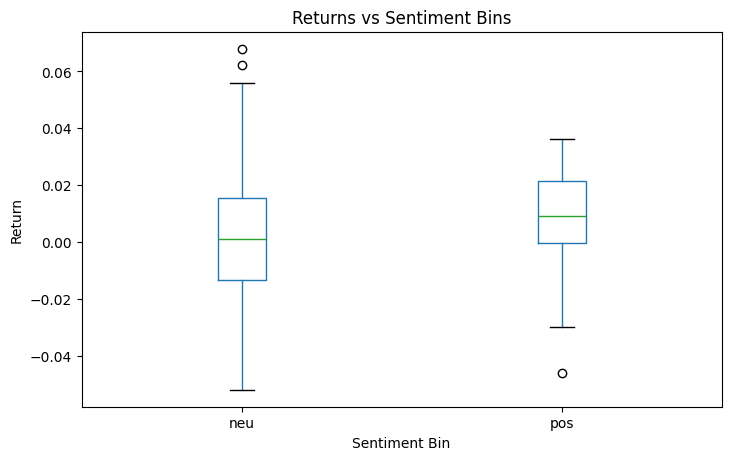

In [59]:
# Generate and save figure 2
if not df.empty and "sentiment_bin" in df.columns:
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    df.boxplot(column="return", by="sentiment_bin", ax=ax2, grid=False)
    ax2.set_title("Returns vs Sentiment Bins")
    ax2.set_xlabel("Sentiment Bin")
    ax2.set_ylabel("Return")
    plt.suptitle("")
    savefig(PROJECT_ROOT / "reports/figures/figure_returns_vs_sentiment_bins.png", fig=fig2, dpi=150)


## Figure 3: PCA Scatter (2D)


## Completed

Figure specifications prepared. Saved outputs will appear in `reports/figures/` after execution.


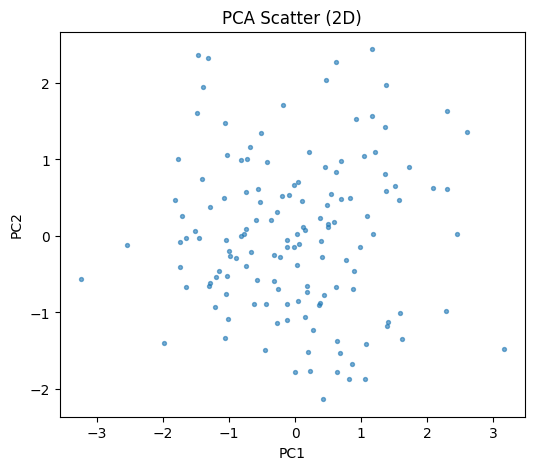

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Generate and save figure 3
if not df.empty:
    feat_cols = ["return", "volume", "volatility", "sentiment_score", "n_headlines"]
    X = df[feat_cols].dropna()
    if not X.empty:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X.values)
        pca = PCA(n_components=2)
        comps = pca.fit_transform(X_scaled)
        fig3, ax3 = plt.subplots(figsize=(6, 5))
        ax3.scatter(comps[:, 0], comps[:, 1], s=8, alpha=0.6)
        ax3.set_title("PCA Scatter (2D)")
        ax3.set_xlabel("PC1")
        ax3.set_ylabel("PC2")
        savefig(PROJECT_ROOT / "reports/figures/figure_pca_scatter.png", fig=fig3, dpi=150)
